In [1]:
%matplotlib inline

import math
import time
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from datetime import date, datetime, time, timedelta
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

print(tf.__version__)

2.9.2


In [3]:
# Colab에서 kaggle 다운로드, kaggle API 업로드
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"eddkang","key":"1a6f4a96f9210e5ef549467b5c2971d4"}'}

In [ ]:
# ls -1ha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Persmisson Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

# kaggle에서 다운로드
!kaggle datasets download -d artemburenok/sp-500-stock-prices

# zip으로 압축되어 있는지 확인하고, 압축 해제
!ls
!unzip sp-500-stock-prices.zip

In [34]:
column_names = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
raw_dataset = pd.read_csv('/content/AAPL.csv', names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True)

dataset = raw_dataset.copy()

# 데이터 셋 확인
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,Date,Open,High,Low,Close,Adj Close,Volume
1,1980-12-12,0.1283479928970337,0.1289059966802597,0.1283479928970337,0.1283479928970337,0.09987378865480423,469033600.0
2,1980-12-15,0.12221000343561172,0.12221000343561172,0.12165199965238571,0.12165199965238571,0.09466331452131271,175884800.0
3,1980-12-16,0.1132809966802597,0.1132809966802597,0.11272300034761429,0.11272300034761429,0.0877152606844902,105728000.0
4,1980-12-17,0.11551299691200256,0.11607100069522858,0.11551299691200256,0.11551299691200256,0.08988628536462784,86441600.0


In [35]:
# 0번 째, Index에 적절한 값이 존재하지 않아서, 0번째 행 제거
dataset = dataset.drop(0)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1,1980-12-12,0.1283479928970337,0.1289059966802597,0.1283479928970337,0.1283479928970337,0.09987378865480423,469033600.0
2,1980-12-15,0.12221000343561172,0.12221000343561172,0.12165199965238571,0.12165199965238571,0.09466331452131271,175884800.0
3,1980-12-16,0.1132809966802597,0.1132809966802597,0.11272300034761429,0.11272300034761429,0.0877152606844902,105728000.0
4,1980-12-17,0.11551299691200256,0.11607100069522858,0.11551299691200256,0.11551299691200256,0.08988628536462784,86441600.0
5,1980-12-18,0.11886200308799744,0.11941999942064285,0.11886200308799744,0.11886200308799744,0.09249228984117508,73449600.0


In [36]:
# NULL 값 제거 
dataset.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [37]:
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset = dataset.set_index('Date')

dataset.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1980-12-12,0.1283479928970337,0.1289059966802597,0.1283479928970337,0.1283479928970337,0.09987378865480423,469033600.0
1980-12-15,0.12221000343561172,0.12221000343561172,0.12165199965238571,0.12165199965238571,0.09466331452131271,175884800.0
1980-12-16,0.1132809966802597,0.1132809966802597,0.11272300034761429,0.11272300034761429,0.0877152606844902,105728000.0
1980-12-17,0.11551299691200256,0.11607100069522858,0.11551299691200256,0.11551299691200256,0.08988628536462784,86441600.0
1980-12-18,0.11886200308799744,0.11941999942064285,0.11886200308799744,0.11886200308799744,0.09249228984117508,73449600.0


In [14]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# train_dataset.tail()
test_dataset.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
10559,2022-10-27,148.07000732421875,149.0500030517578,144.1300048828125,144.8000030517578,144.56019592285156,109180200.0
10561,2022-10-31,153.16000366210938,154.24000549316406,151.9199981689453,153.33999633789062,153.08604431152344,97943200.0
10563,2022-11-02,148.9499969482422,152.1699981689453,145.0,145.02999877929688,144.78981018066406,93604600.0
10573,2022-11-16,149.1300048828125,149.8699951171875,147.2899932861328,148.7899932861328,148.7899932861328,64218300.0
10575,2022-11-18,152.30999755859375,152.6999969482422,149.97000122070312,151.2899932861328,151.2899932861328,74829600.0


In [15]:
train_stats = train_dataset.describe()
# train_stats.pop("Close")
train_stats = train_stats.transpose()
train_stats

,count,unique,top,freq
Date,8474,8474,1989-10-31,1
Open,8474,4950,0.3549109995365143,33
High,8474,4890,0.375,29
Low,8474,4858,0.35714301466941833,38
Close,8474,5025,0.3995540142059326,31
Adj Close,8474,6297,0.08597838878631592,17
Volume,8474,8102,246400000.0,7


In [ ]:
train_labels = train_dataset.pop('Close')
test_labels = test_dataset.pop('Close')

In [ ]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 [==============================] - 2s 2s/step


array([[ 0.02716354],
       [ 0.14838114],
       [ 0.14912665],
       [ 0.26960063],
       [-0.31427467],
       [ 0.05290012],
       [-0.2992591 ],
       [ 0.16353296],
       [-0.02156638],
       [-0.49098864]], dtype=float32)

In [ ]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.723202,1.053166,2.723202,9.268743,2.299346,9.268743,995
996,2.783911,1.017628,2.783911,9.000381,2.256803,9.000381,996
997,2.735310,1.041210,2.735310,8.505968,2.242581,8.505968,997
998,2.744558,1.034786,2.744558,8.884104,2.267896,8.884104,998
999,2.708888,1.025816,2.708888,9.039669,2.333457,9.039669,999


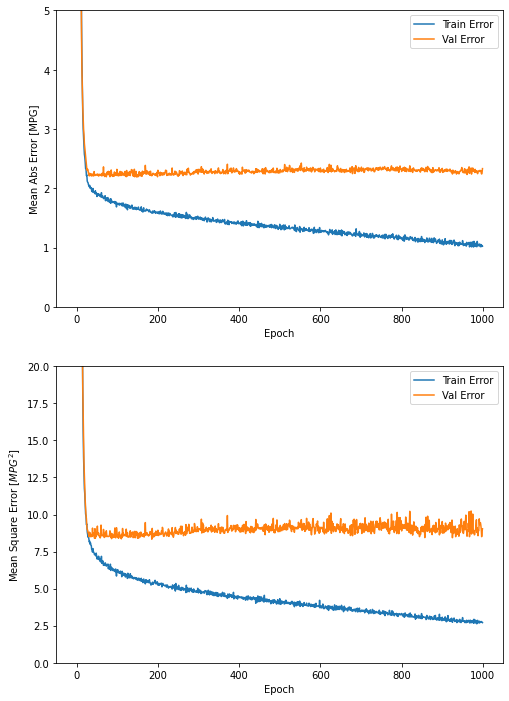

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


..........................................................................

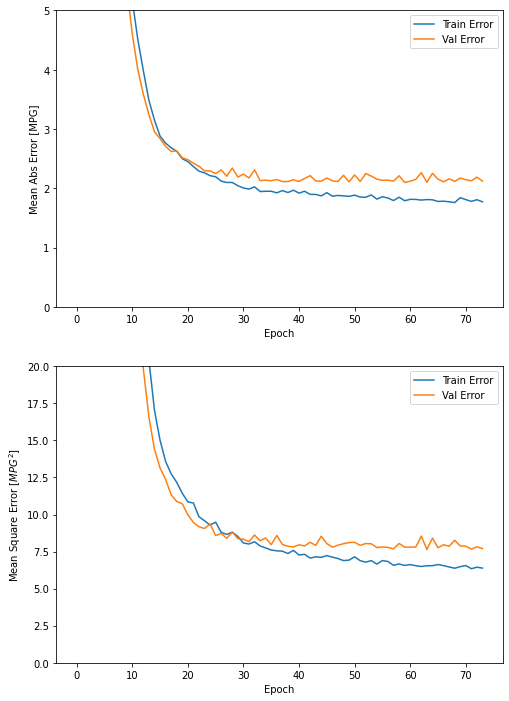

In [ ]:
model = build_model()

# patience 매개변수는 성능 향상을 체크할 에포크 횟수입니다
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 5.7152 - mae: 1.9088 - mse: 5.7152 - 22ms/epoch - 7ms/step
테스트 세트의 평균 절대 오차:  1.91 MPG


3/3 [==============================] - 0s 5ms/step


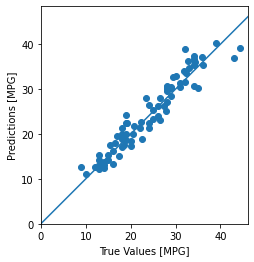

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

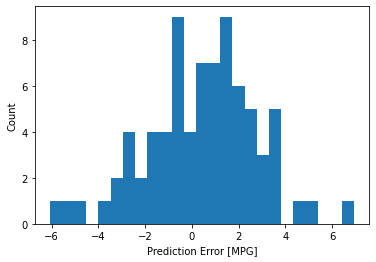

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")